In [1]:
%matplotlib inline

In [2]:
from gpitch.matern12_spectral_mixture import MercerMatern12sm
from gpitch.myplots import plot_predict
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpitch
import gpflow

In [3]:
# gpu usage
gpitch.init_settings();
plt.rcParams["figure.figsize"] = (12, 4)

In [4]:
# load audio
path = "../data/"
fname = "011PFNOF_M60_train.wav"
x, y, fs = gpitch.readaudio(path + fname)
f0 = gpitch.find_ideal_f0([fname])
print f0

[261.6255653005986]


number of inducing variables 109


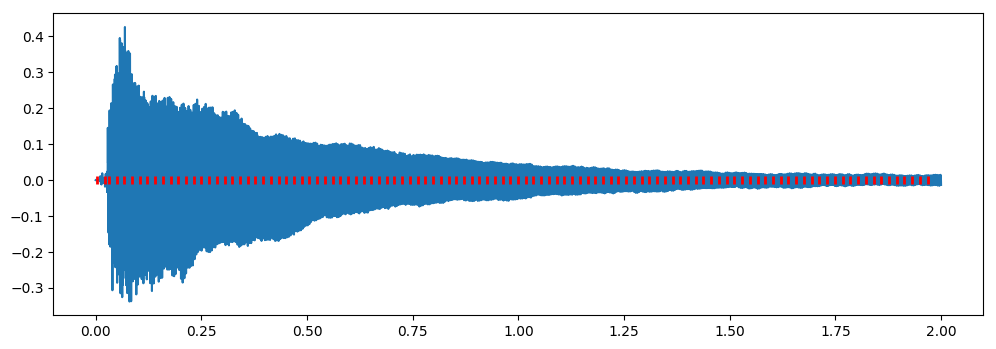

In [5]:
#  use maxima as inducing points
z, u = gpitch.init_liv(x=x, y=y, win_size=31, thres=0.033, dec=9)
print("number of inducing variables {0}".format(u.size))

plt.figure()
plt.plot(x, y)
plt.plot(z[0][0], 0.*u, '|r', mfc="none", ms=6, mew=2)

In [6]:
# init activation kernel
kact = gpflow.kernels.Matern32(input_dim=1, lengthscales=1.0, variance=1.0)

# init component kernel
npartials = 5
enr = np.ones((npartials))
frq = f0*np.array(range(1, npartials + 1))
kcom = MercerMatern12sm(input_dim=1, energy=enr, frequency=frq)
kern = [[kact], [kcom]]

In [7]:
# init model
m = gpitch.pdgp.Pdgp(x=x.copy(), y=y.copy(), z=z, kern=kern, minibatch_size=100)
m.za.fixed = True
m.zc.fixed = True

In [8]:
# optimization
method = tf.train.AdamOptimizer(learning_rate=0.0025)
m.optimize(method=method, maxiter=10000)

     fun: -69427.329731106103
     jac: array([ -2.58164600e+03,   5.69960146e+03,   8.13247993e+02, ...,
         1.54513767e-01,  -2.24404996e-01,  -1.57060345e-01])
 message: 'Finished iterations.'
  status: 'Finished iterations.'
 success: True
       x: array([ 0.89183367,  1.03690284,  4.05832648, ...,  0.11402743,
        0.33058285,  0.67801757])

In [9]:
# predict
xtest = x[::3].copy()
mu_a, var_a, mu_c, var_c, m_src = m.predict_act_n_com(xtest)

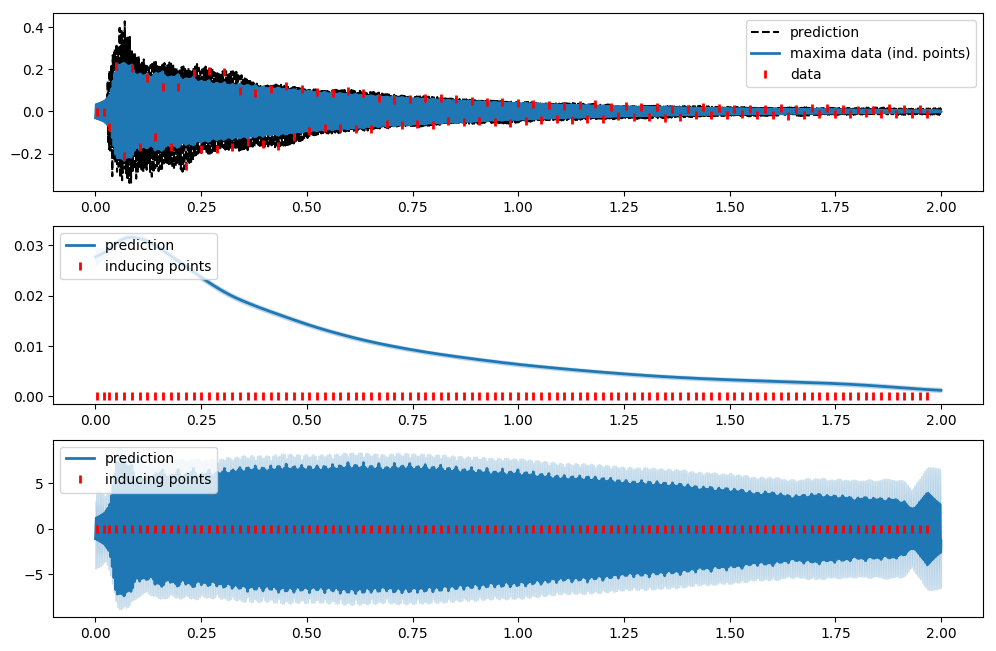

In [10]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(x, y, 'k--')
plt.plot(xtest, m_src[0], lw=2)
plt.plot(z[0][0], u, '|r', mfc="none", ms=6, mew=2)
plt.legend(['prediction', 'maxima data (ind. points)', 'data'])

plt.subplot(3, 1, 2)
plot_predict(x=xtest, mean=mu_a[0], var=var_a[0], z=m.za[0].value, latent=True)
plt.legend(['prediction', 'inducing points'], loc=2)

plt.subplot(3, 1, 3)
plot_predict(x=xtest, mean=mu_c[0], var=var_c[0], z=m.zc[0].value)
plt.legend(['prediction', 'inducing points'], loc=2)
plt.savefig("demo-modgp.png")
plt.show()

In [11]:
m.kern_com

Name,values,prior,constraint
kern_com.item0.energy.item0,[ 4.07545783],None,+ve
kern_com.item0.energy.item1,[ 0.00049601],None,+ve
kern_com.item0.energy.item2,[ 0.00039501],None,+ve
kern_com.item0.energy.item3,[ 0.00051913],None,+ve
kern_com.item0.energy.item4,[ 0.00029242],None,+ve
kern_com.item0.frequency.item0,[ 253.16350161],None,+ve
kern_com.item0.frequency.item1,[ 525.56897437],None,+ve
kern_com.item0.frequency.item2,[ 785.0370687],None,+ve
kern_com.item0.frequency.item3,[ 1046.64391251],None,+ve
kern_com.item0.frequency.item4,[ 1307.80083915],None,+ve
